# Melting Point Prediction with Large Dataset

This notebook loads and cleans an expanded dataset of organic compounds, uses an ensemble of XGBClassifier and MLPClassifier to split melting points into bins (low, mid, high), and predicts melting points with bin specific XGBRegressors. 


## Utility Functions

Below are helper functions used throughout this notebook for feature generation, selection, and binning.


In [1]:
from src.modeling.featurization import (
    get_rdkit_descriptors,
    featurize_smiles_dataframe,
    compute_feature_importance,
)


## 1. Import Libraries and Load Data

First, we import the necessary libraries and load the large extra dataset as well as the test dataset. Proper encoding and error handling are applied to ensure clean data ingestion.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_data = pd.read_csv(
    'data/raw/nadinulrich_extra_data.csv',
    delimiter=';',
    encoding='latin1',      # to avoid UnicodeDecodeError
    quotechar='"',          # so text inside quotes is handled properly
    on_bad_lines='skip'     # for pandas >=1.3.0 replace error_bad_lines=False with this
)

df_test = pd.read_csv('data/raw/test.csv')

# Rename columns
df_data.rename(columns={
    'Number': 'id',
    'MP': 'Tm'
}, inplace=True)

## 2. Data Cleaning and Preprocessing

We standardize column names, select the canonical SMILES strings to match the test data format, and filter out entries excluded for various reasons.

Melting points are converted from Celsius to Kelvin and cleaned of any missing or invalid values.

Finally, we exclude any compounds that appear in the test set to avoid data leakage during model training.


In [3]:
# Pick the canoncial SMILES column that matches test dataset
df_data['SMILES'] = df_data['canoncial SMILES']
# Remove compounds with exclusion reasons
df_data = df_data[df_data['reason for exclusion'].fillna('') == '']
df_data['Tm'] = pd.to_numeric(df_data['Tm'], errors='coerce')

# Keep only relevant columns, convert Tm to Kelvin, drop NaNs, and remove test set compounds
df_data = df_data[['id', 'SMILES', 'Tm']]
df_data['Tm'] = df_data['Tm'] + 273.15
df_data = df_data.dropna()
df_data = df_data[~df_data['SMILES'].isin(df_test['SMILES'])]

## 3. Save Cleaned Data

The cleaned dataset is saved to disk for easy reuse without repeating the entire cleaning process.

In [4]:
# Save cleaned data
# df_data.to_csv('data/processed/cleaned_extra_data.csv', index=False)

## 4. Exploratory Data Analysis: Melting Point Distribution

We plot a histogram of the melting points to understand their distribution and identify appropriate bins to separate compounds into low, medium, and high melting point groups.

Red dashed lines at 300 K and 500 K indicate initial proposed bin edges. 

Each bin distribution is printed below. This informs us about class balance and data availability per bin, which will guide model training strategies.


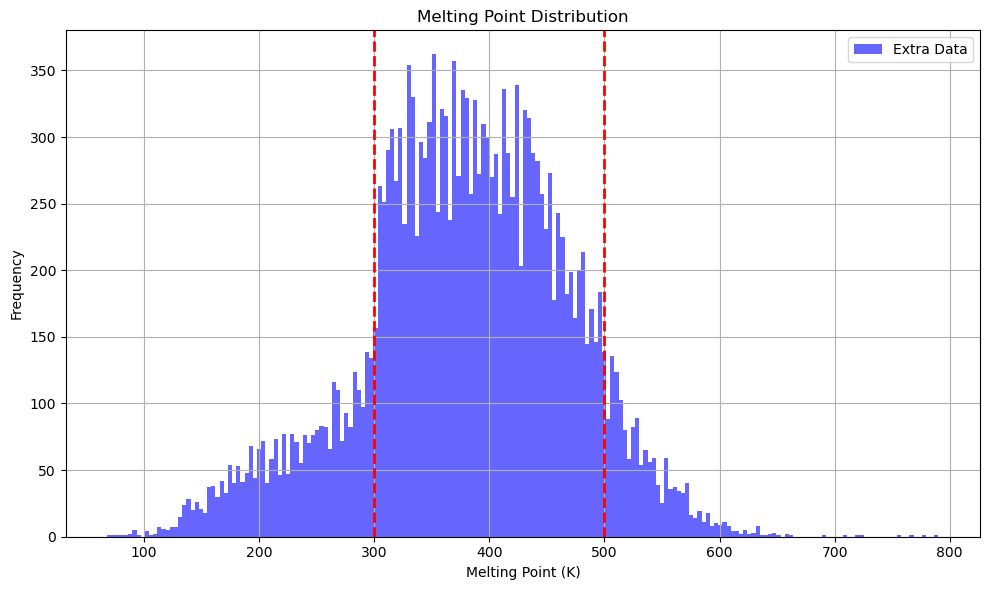

Tm
[300, 500)     14627
[0, 300)        3025
[500, 1000)     1531
Name: count, dtype: int64


In [5]:
# Plot histogram of Tm values from df_data and df_test
plt.figure(figsize=(10, 6))

plt.hist(df_data['Tm'], bins=200, alpha=0.6, label='Extra Data', color='blue')
plt.xlabel('Melting Point (K)')
plt.ylabel('Frequency')
plt.title('Melting Point Distribution')
plt.legend()
plt.grid(True)
plt.axvline(x=300, color='red', linestyle='--', linewidth=2, label='x=300')
plt.axvline(x=500, color='red', linestyle='--', linewidth=2, label='x=500')
plt.tight_layout()
plt.show()

bin_edges = [0, 300, 500, 1000]

counts = pd.cut(df_data['Tm'], bins=bin_edges, right=False).value_counts()
print(counts)

## 6. Feature Generation and Selection

To build effective models, we convert SMILES strings into molecular descriptors using RDKit's built-in descriptor functions. We exclude certain descriptors known to be less informative or problematic.

Next, we use a Random Forest classifier to compute feature importances and select the top features that cumulatively explain 95% of the importance. This reduces dimensionality and helps improve model performance.


In [6]:
# Load cleaned large dataset
df = pd.read_csv('data/processed/cleaned_extra_data.csv')

# Define bin edges and labels (from previous analysis)
bin_edges = [0, 300, 500, 1000]
bin_labels = [0, 1, 2] # 0: low, 1: medium, 2: high

# Bin melting points for classification task
df['Tm_bin'] = pd.cut(df['Tm'], bins=bin_edges, labels=bin_labels, include_lowest=True).astype(int)

# Get descriptor functions excluding some
descriptor_funcs = get_rdkit_descriptors()

# Featurize dataset (compute descriptors)
feature_df, valid_indices = featurize_smiles_dataframe(df, 'SMILES', descriptor_funcs)

# Keep only rows successfully featurized
df = df.loc[valid_indices].reset_index(drop=True)

# Prepare feature matrix and labels for feature importance
X = feature_df.values
y = df['Tm_bin']

# Compute feature importances and select top features explaining 95% cumulative importance
top_features_df = compute_feature_importance(X, y, feature_df.columns.tolist(), threshold=0.95)

# List of selected feature names
top_features = top_features_df['Feature'].tolist()
top_feature_data = feature_df[top_features].reset_index(drop=True)

# Concatenate base df with top features in one operation
df = pd.concat([df.reset_index(drop=True), top_feature_data.reset_index(drop=True)], axis=1)

# Optional: de-fragment DataFrame for best performance
df = df.copy()


print(f"Selected top {len(top_features)} features out of {len(feature_df.columns)} total features.")


Featurizing: 100%|██████████| 19183/19183 [01:33<00:00, 204.56it/s]


Selected top 115 features out of 211 total features.


### Summary

- Generated molecular descriptors from SMILES strings for all compounds.
- Filtered dataset to include only valid descriptor calculations.
- Binned melting points into three categories: Low, Medium, High.
- Selected the top ~95% most important features using a Random Forest classifier.

These features will be used in the subsequent modeling steps to train bin-specific regressors.


## 7. Classification of Melting Point Bins

In this section, we build classifiers to predict melting point bins (low, medium, high). We use XGBoost classifiers with hyperparameter tuning and evaluate performance on each bin. We will also leverage an MLP classifier and create an ensemble by optimizing per-class weights to combine the two models.

First we import helper functions as well as needed libraries:


In [7]:
# Imports
from src.modeling.classifier import (
    train_multiclass_classifier,
    plot_classification_report,
    MLPClassifier,
    train_mlp_classifier,
    train_ensemble_weights,
    ensemble_probabilities,
    prepare_data,
    MolDataset
)
from src.modeling.featurization import featurize_smiles_dataframe, get_rdkit_descriptors

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 7.1 Data Preparation

In [8]:
target_col = 'Tm_bin'

X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_data(df, top_features, target_col)

train_dataset = MolDataset(X_train, y_train)
val_dataset = MolDataset(X_val, y_val)
test_dataset = MolDataset(X_test, y_test)


## 7.2 XGBoost Classifiers Per Melting Point Bin

--NOTE--
A hyperparameter grid was defined for the XGBoost classifiers. Below is an example of what a param_grid would look like. For brevity, the best features will be loaded in the final model.


Using the previously selected top features, we append these features to our main dataset and perform classification within each melting point bin. The per_bin_classification utility performs hyperparameter tuning via grid search and evaluates the models on a test split.

In [9]:
param_grid = {
    'max_depth': [3, 6],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1]
}

results = train_multiclass_classifier(df, features=top_features, target_col='Tm_bin', param_grid=param_grid)

c:\Users\skyle\miniconda3\envs\melting_point\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\skyle\miniconda3\envs\melting_point\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\skyle\miniconda3\envs\melting_point\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\skyle\miniconda3\envs\melting_point\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\skyle\miniconda3\envs\melting_point\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\skyle\miniconda3\envs\melting_point\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_l

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

Test Accuracy: 0.888
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       605
           1       0.90      0.96      0.93      2925
           2       0.72      0.42      0.53       306

    accuracy                           0.89      3836
   macro avg       0.83      0.72      0.76      3836
weighted avg       0.88      0.89      0.88      3836




```python
# TRUE PARAMETERS FOR XGBCLASSIFIER
xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    n_jobs=-1,
    random_state=42,
    max_depth=7,
    learning_rate=0.011,
    n_estimators=300,
    subsample=0.7,
    colsample_bytree=0.9,
    gamma=0.9
)
```



### 7.2 Training an MLP Classifier on Melting Point Bins

We now prepare the dataset for training a Multi-Layer Perceptron (MLP) classifier using PyTorch. The dataset is split into training and test sets with stratification to preserve class distributions.

Features are standardized using `StandardScaler` to improve model convergence.

The data is wrapped into PyTorch `DataLoader`s for efficient mini-batch training.

We initialize the MLP model with the appropriate input dimension and train it with early stopping based on validation loss to avoid overfitting.

Below is the code for data preparation and MLP training:



In [10]:
# Prepare data for MLP
X_train, X_test, y_train, y_test = train_test_split(
    df_data_features[top_features].values, df_data_features['Tm_bin_encoded'].values, 
    test_size=0.2, random_state=42, stratify=df_data_features['Tm_bin_encoded']
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create PyTorch DataLoaders
batch_size = 64

train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize and train MLP
input_dim = X_train_scaled.shape[1]
mlp_model = MLPClassifier(input_dim=input_dim)

mlp_model = train_mlp_classifier(mlp_model, train_loader, val_loader, epochs=100, lr=1e-3, patience=10)


NameError: name 'df_data_features' is not defined

In [ ]:
mlp_model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    outputs = mlp_model(X_test_tensor)
    _, y_pred_mlp = torch.max(outputs, 1)

print("MLP Classification Report")
plot_classification_report(y_test, y_pred_mlp.numpy(), class_names=bin_labels)


In [ ]:
# Collect XGB predictions on test set (assuming we have a single combined model or aggregate from bins)
# For simplicity, use bin models to get predictions for all test samples in respective bins:

def get_xgb_probs_for_test_samples(results, df, features, scaler, label_map):
    """Return XGB probabilities for all samples in df, by bin."""
    xgb_probs = np.zeros((len(df), len(label_map)))

    for bin_label, bin_idx in label_map.items():
        bin_df = df[df['Tm_bin_encoded'] == bin_idx]
        if bin_df.empty:
            continue

        model_info = results.get(bin_idx)
        if model_info is None:
            continue

        X_bin = bin_df[features].values
        X_bin_scaled = model_info['scaler'].transform(X_bin)
        probs = model_info['model'].predict_proba(X_bin_scaled)

        xgb_probs[bin_df.index, :] = probs

    return xgb_probs

xgb_probs_test = get_xgb_probs_for_test_samples(results, df_data_features.loc[X_test_scaled.index], top_features, scaler, label_map)

# MLP probs
mlp_probs_test = torch.softmax(outputs, dim=1).numpy()

# Optimize ensemble weights
optimized_weights = train_ensemble_weights(mlp_probs_test, xgb_probs_test, y_test)
print(f"Optimized ensemble weights per class: {optimized_weights}")

# Compute ensemble probabilities
weights_dict = {f"alpha_extra_{i}": optimized_weights[i] for i in range(len(optimized_weights))}
ensemble_probs = ensemble_probabilities(mlp_probs_test, xgb_probs_test, weights_dict)

# Ensemble predictions
y_pred_ensemble = np.argmax(ensemble_probs, axis=1)

print("Ensemble Classification Report")
plot_classification_report(y_test, y_pred_ensemble, class_names=bin_labels)
